In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from pyddx.sc import dmsuite as dms

In [2]:
class AOUR: 
    
    def __init__(self, B, mu, gamma, Dr, c, N):
        self.B = B 
        self.mu = mu 
        self.gamma = gamma 
        self.Dr = Dr 
        self.c = c
        self.N = int(N) 
        self.size = N + 1 
        self._set_up_cheb()
        
    def evolve(self, T, n_frames, dt): 
        y = np.zeros((self.size))
        y[-1] = 1 
        self.h = np.empty((n_frames, self.N))
        self.p = np.empty(n_frames)
        self.M = np.linalg.inv(np.eye(self.N) + self.B*self.D4*dt) # use backward time-step
        for i in range(n_frames):
            for j in range(int(T/n_frames/dt)):
                y = self._update(y, dt)
            self.h[i, :] = y[:self.N]
            self.p[i] = y[-1]
                
    def _set_up_cheb(self):
        x, D = dms.chebdif(self.N+4, 4)   # this cursed algorithm has x backward    
        self.x = x[2:-2]/2 + 0.5
        D1 = D[0, :, :]                   # first derivative
        D2 = D[1, :, :]                   # second derivative
        D3 = D[2, :, :]
        D4 = D[3, :, :]
        
        # set up boundary conditions 
        M = np.array([np.eye(N+4)[-1], D1[-1], D2[0], D3[0]])
        M_bc = np.stack(M)
        M_bc = np.roll(M_bc, -2, axis=-1) # in the order of [-2, -1, 0, 1]
        M0 = M_bc[:, :-4]
        invM1 = np.linalg.inv(M_bc[:, -4:])
        
        D4_alt = np.roll(D4, -2, axis=-1)
        D4_bulk = D4_alt[2:-2, :-4] # cut off boundary in the unrolled dimension, cut off last 4 elements in the rolled dimension
        D4_bc = D4_alt[2:-2, -4:]
        self.D4 = (D4_bulk - D4_bc @ invM1 @ M0)*16 # times 16 to make up for L = 2 in the package 

        
    def _update(self, y, dt): 
        h = y[:self.N]
        p = y[self.N]
                
        h[0] += self.mu*p*dt 
        h_new = self.M @ h 
        p += self.gamma*(-p*dt + np.sqrt(dt*self.Dr)*np.random.normal())
        p += self.c*(h_new[0]-h[0])
        return np.append(h_new, [p]) 
        
    def h_corr(self, omegas): 
        omegas = omegas[:, np.newaxis]
        vals, fs = self._find_eigs()
        fs = fs[np.newaxis, :]
        lbdas = self.B*vals[np.newaxis, :] 
        temp = np.sum(fs**2/(1j*omegas + lbdas), axis=-1)[:, np.newaxis]
        temp = 1/(self.gamma + 1j*omegas*(1-self.c*self.mu*temp))
        h_nw = self.mu*fs/(1j*omegas+lbdas)*temp
        return np.abs(h_nw)**2 
    
    def _find_eigs(self): 
        vals, vecs = np.linalg.eig(m.D4)
        fs = (vecs[:, 0])
        return vals, fs 

In [3]:
def find_corr(x, y):
    corr = np.correlate(x, y, mode='full')
    L = x.size
    n = np.arange(1, L+1)
    return corr[:L]/n

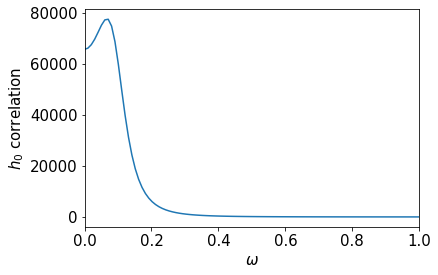

In [51]:
Dr = 10 # amplitude of p 
N = 64

gamma = 0.1
B = 0.1/((0.6*np.pi)**4)
mu = 1/0.225
c = (gamma + B*(0.6*np.pi)**4)/mu/0.225
T = 5e2
dt = 1e-3 

dryrun = True
repeats = 10

if dryrun: 
    m = AOUR(B, mu, gamma, Dr, c, N)
else: 
    ms = [] 
    for r in range(repeats):
        m = AOUR(B, mu, gamma, Dr, c, N)
        m.evolve(T, int(T), dt)
        ms.append(m)
        
omegas = np.linspace(0, 1, 100)
h_corr = m.h_corr(omegas)
index = np.argmax(h_corr[0, :])
plt.plot(omegas, h_corr[:, index])
plt.xlabel(r'$\omega$')
plt.ylabel('$h_0$ correlation')
plt.xlim([0, 1])
plt.show()

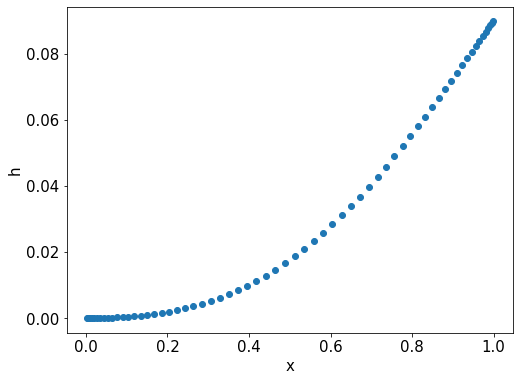

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(m.x, m.h[-1], 'o')
plt.xlabel('x')
plt.ylabel('h')
plt.show() 

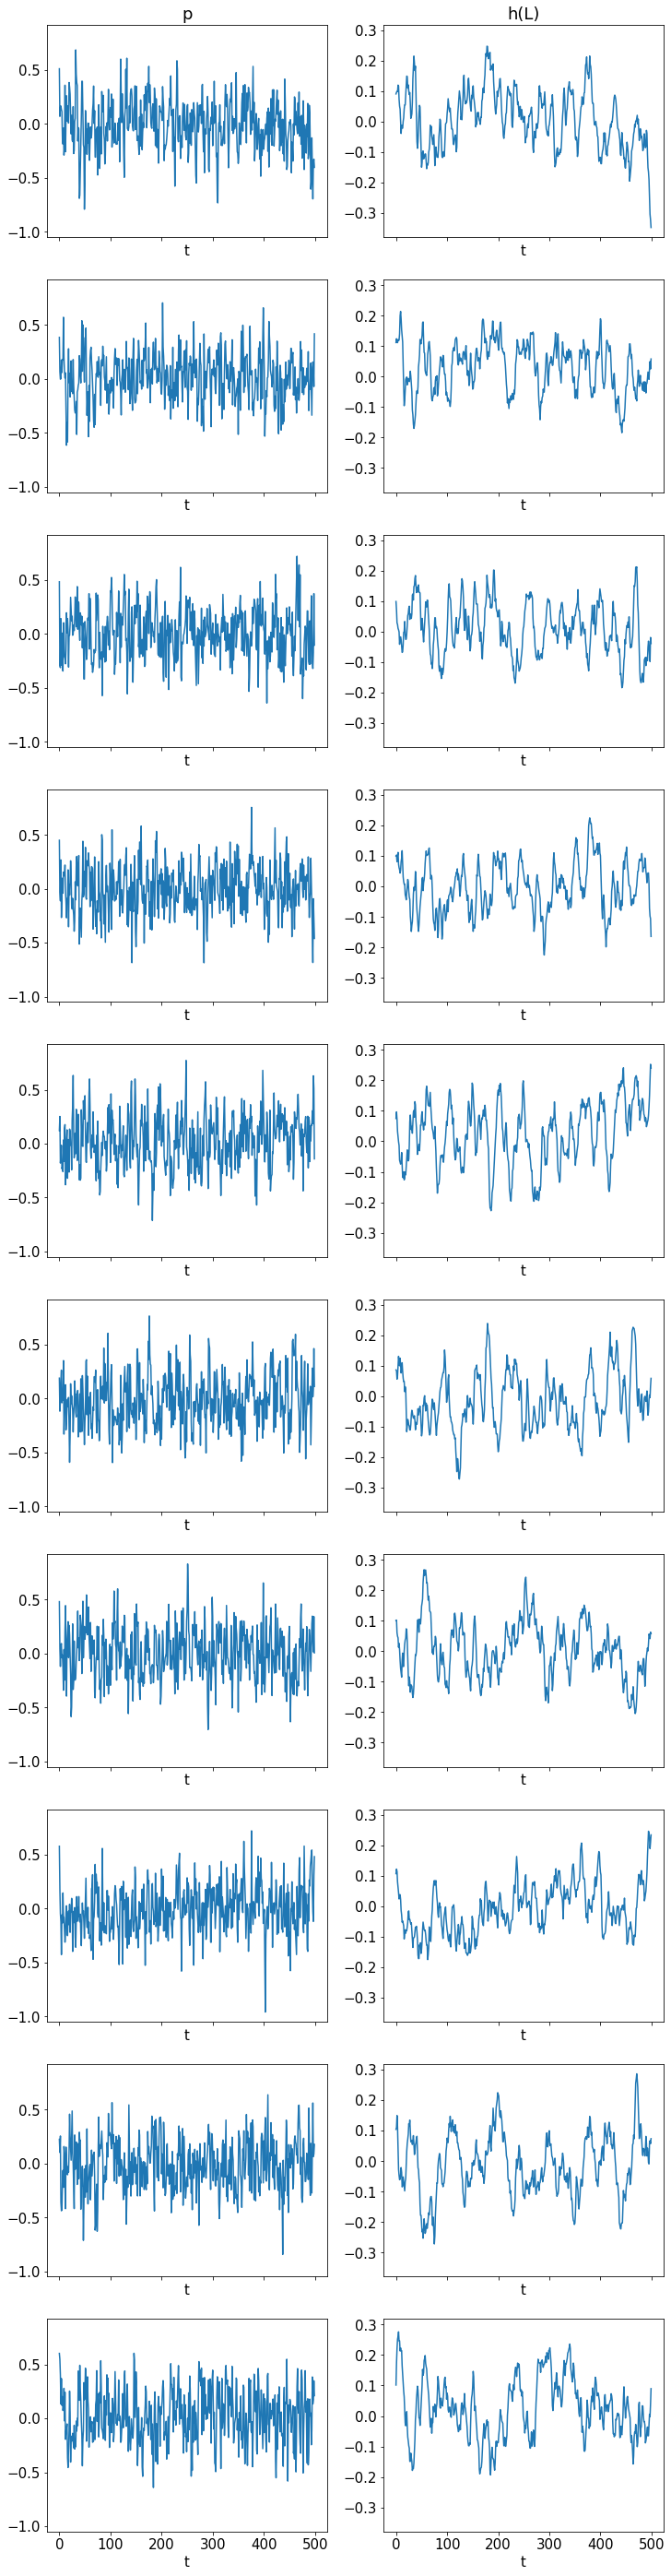

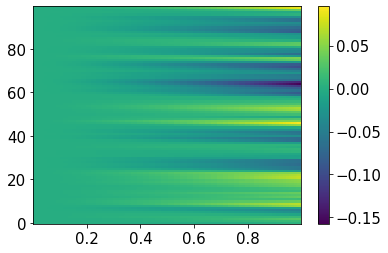

In [44]:
fig, axes = plt.subplots(repeats, 2, sharey='col', sharex=True, figsize=(12, 5*repeats))

for i in range(repeats): 
    axes[i, 0].plot(ms[i].p)
    axes[i, 0].set_xlabel('t')


    axes[i, 1].plot(ms[i].h[:, 0])
    axes[i, 1].set_xlabel('t')
    
axes[0, 0].set_title('p')
axes[0, 1].set_title('h(L)')
plt.show() 

t = 100
plt.pcolor(m.x, np.arange(int(t)), m.h[-int(t):, ])
plt.colorbar() 
plt.show() 

AttributeError: 'AOUR' object has no attribute 'p'

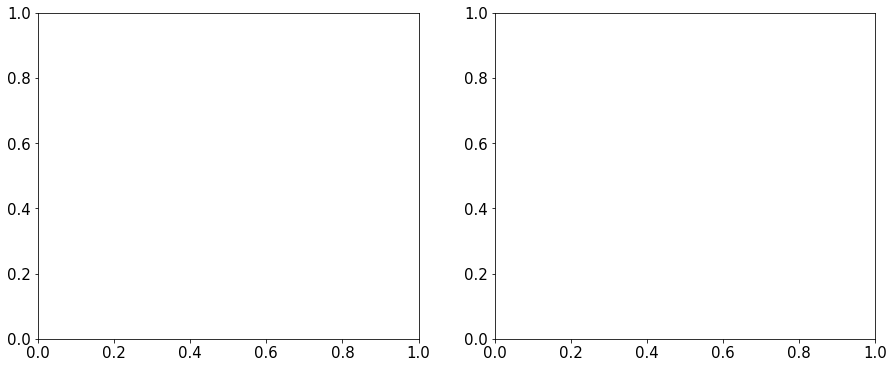

In [52]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 6))
omegas = np.fft.fftfreq(int(T))*2*np.pi
axes[0].plot(omegas[:100], np.abs(np.fft.fft(m.p))[:100], 'o', markersize=5)
axes[0].set_xlabel('$\omega$')
axes[0].set_ylabel('$p(\omega)$')


axes[1].plot(omegas[:100], np.abs(np.fft.fft(m.h[:, 0]))[:100], 'o', markersize=5)
axes[1].set_xlabel('$\omega$')
axes[1].set_ylabel('$h(\omega, L)$')

plt.savefig('Figures/fft.png')
plt.show() 

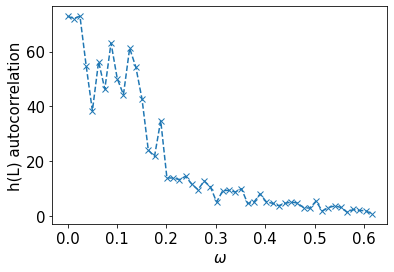

In [58]:
# z = np.array([m.h[:, 0] for m in ms])
corr_mean = np.mean(np.abs(np.fft.fft(z))**2, axis=0)
omegas = np.fft.fftfreq(int(T))*2*np.pi
plt.plot(omegas[:50], corr_mean[:50], 'x--')

h_corr = m.h_corr(omegas)
# plt.plot(omegas[:50], h_corr[:50, index]/1000)
plt.xlabel(r'$\omega$')
plt.ylabel('h(L) autocorrelation')
plt.show() 

In [39]:
z = np.array([m.h[:, 0] for m in ms])
p = np.array([m.p for m in ms])

corrs_z = [] 
corrs_p = [] 
for m in ms: 
    z = m.h[:, 0]
    p = m.p 
    corr_z = find_corr(z, z)
    corr_p = find_corr(p, p)
    corrs_z.append(corr_z)
    corrs_p.append(corr_p)

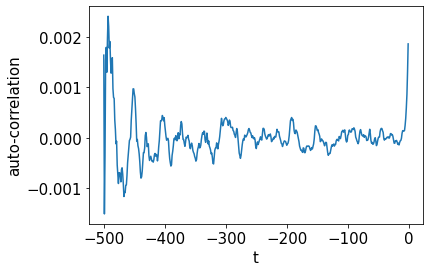

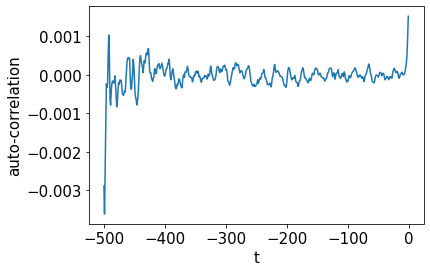

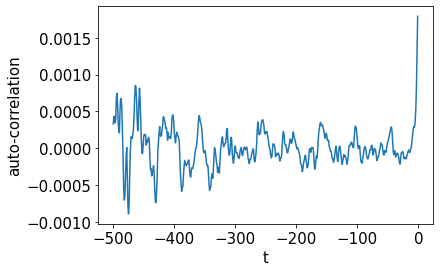

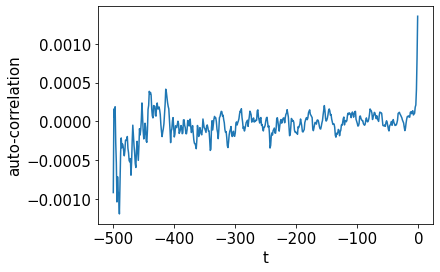

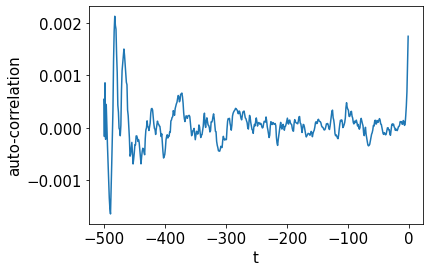

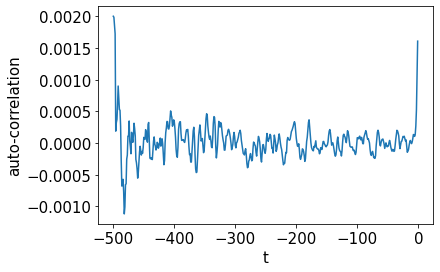

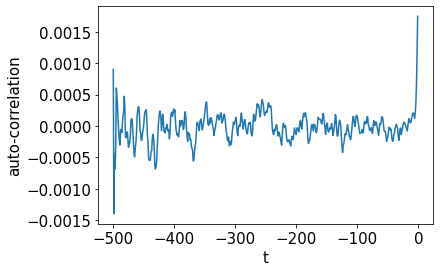

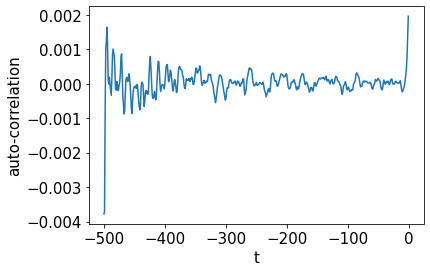

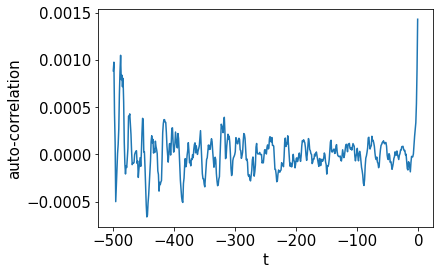

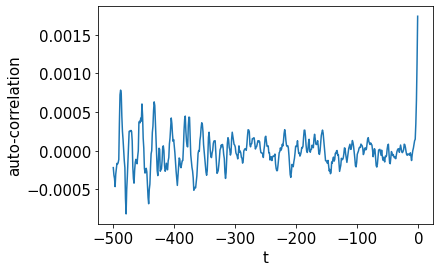

In [40]:
for i in range(repeats):
    plt.plot(np.arange(-T, 0), corrs_z[i], label='corr z(L)')
#     plt.plot(corrs_p[i], label='corr p')
#     plt.legend()
    plt.xlabel('t')
    plt.ylabel('auto-correlation')
    plt.show() 

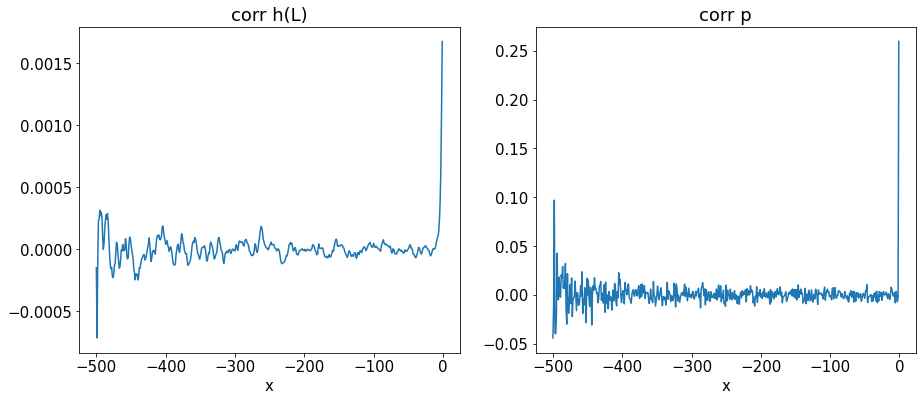

In [41]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 6))

axes[0].plot(np.arange(-T, 0), np.mean(corrs_z, axis=0))
axes[0].set_title('corr h(L)')
axes[0].set_xlabel('x')
axes[1].plot(np.arange(-T, 0), np.mean(corrs_p, axis=0))
axes[1].set_title('corr p')
axes[1].set_xlabel('x')
plt.show() 